In [1]:
import random
import numpy as np
import statistics

import matplotlib.pyplot as plt

from IncrementalLOF import IncrementalLOF
from dilof import DILOF

from kdwer import KDEWRStreaming

from milof import milof

import tqdm

In [2]:
def generate_dataset(n_samples, centers, stdevs, center_weights, outlier_center, outlier_spread, outlier_prop, outlier_sequence = False, outlier_sequence_length = 5):
    dimension = len(centers[0])

    X = np.empty((n_samples, dimension))
    labels = np.empty(n_samples)

    i = 0
    while i < n_samples:
        #Do a biased coin flip to decide whether we have an outlier or not
        if random.random() < outlier_prop:
            #Then we have an outlier
            c = random.choices(range(len(outlier_center)))[0]
            sample = np.random.multivariate_normal(mean = outlier_center[c],
                                                   cov = np.diag([outlier_spread[c]] * dimension))
            
            X[i] = sample
            labels[i] = -1 #Outlier
            i += 1

            if outlier_sequence:
                seq_length = 1
                while random.random() < 0.3 and seq_length <= outlier_sequence_length:
                    #Then get another outlier from that center
                     sample = np.random.multivariate_normal(mean = outlier_center[c],
                                                   cov = np.diag([outlier_spread[c]] * dimension))
            
                     X[i] = sample
                     labels[i] = -1 #Outlier
                     i += 1
                     seq_length += 1
        else:
            #Not an outlier. Sample from regular centers
            c = random.choices(range(len(centers)), weights = center_weights)[0]
            sample = np.random.multivariate_normal(mean = centers[c],
                                                   cov = np.diag([stdevs[c]] * dimension))
            
            X[i] = sample
            labels[i] = c #Center index

            i += 1

    
    return (X, labels)

In [3]:
# Generate a large dataset with sequences of outliers
random.seed(52)
X, y = generate_dataset(
                        n_samples = 5000,
                        centers = [[0,0], [7,7], [0,5]],
                        stdevs = [0.5,2,0.5],
                        center_weights = [0.75 / 2, 0.25, 0.75 / 2],
                        outlier_center = [[12, -2], [0,30], [0, -7.5]],
                        outlier_spread = [4, 10, 2],
                        outlier_prop = 0.01,
                        outlier_sequence = True,
                        outlier_sequence_length = 3
)

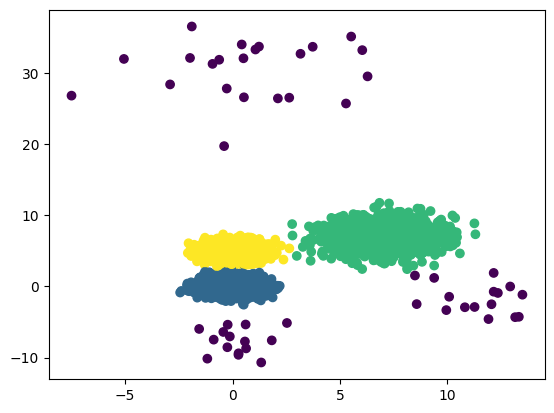

In [4]:
plt.scatter(x = X[:,0], y = X[:,1], c = y)

In [5]:
def test(data, method, k = 30, threshold = 1, window_size = 200, skipping_enabled = False, num_clusters = 10,
         r = 1, xi = 0.5, forgetting = 0.9):
    """
    Takes an array/list of tuples, data, and a outlier detection method (IncrementalLOF, DILOF, MILOF, KDEWR)
    and runs that algorithm on data. Returns a list of the same length as data of the decisions made by the algo.
    0 for non-outlier, -1 for outlier
    """
    match method:
        case "IncrementalLOF":
            alg = IncrementalLOF(k = k, threshold = threshold)
        case "DILOF":
            alg = DILOF(k = k,
                        threshold = threshold,
                        window_size = window_size,
                        step_size = 0.1,
                        regularizer = 0.001,
                        max_iter = 50,
                        skipping_enabled = skipping_enabled)
        case "MILOF":
            alg = milof(
                    k = k,
                    b = window_size,
                    threshold = threshold,
                    c = num_clusters
            )
        case "KDEWR":
            alg = KDEWRStreaming(
                windowSize = window_size, 
                dim = len(data[0]),
                r = r,
                xi = xi,
                forgetting = forgetting)
    
    classification = []
    scores = []
    for d in tqdm.tqdm(data):
        (decision, score) = alg.insert(d)
        scores.append(score)
        classification.append(decision)
    
    return (classification, scores)

In [6]:
def f1_score(estimated, actual):
    """
    Assume they're both bool lists of equal length. True = outlier, False = not outlier
    """
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    true_negatives = 0

    for i in range(len(estimated)):
        if estimated[i] == actual[i]:
            if actual[i] == True:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if actual[i] == True:
                #Then estimated didn't pick up on it
                false_negatives += 1
            else:
                false_positives += 1
    
    f1_score = 2*true_positives / (2*true_positives + false_positives + false_negatives)

    return f1_score


In [ ]:
(classification, scores) = test( data = X[:1000], method = "KDEWR", 
                                k = 30, 
                                window_size = 100,
                                r = 1,
                                xi = 0.1,
                                forgetting = 0.8
                                )

100%|██████████| 1000/1000 [00:41<00:00, 23.88it/s]


In [7]:
actual = [x == -1 for x in y]

#f1_score(classification, actual)

#plt.hist([scores[i] for i in range(len(scores)) if actual[i] == True], bins = 100)

In [8]:
f_scores = [[], [], [], []]
algs = ["IncrementalLOF", "DILOF", "MILOF"]#, "KDEWR"]
#algs = ["MILOF"]
#windows = [100,250,500,750,1000]
windows = [100,200,300,400,500]
for w in windows:
    for i in range(1, len(algs)):
        (c,s) = test(
                     data = X,
                     method = algs[i],
                     k = 30,
                     threshold = 2,
                     window_size = w,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
        )
        f_scores[i].append(f1_score(c, actual))

#Do incremental
(c,s) = test(
            data = X,
            method = "IncrementalLOF",
            k = 50,
            threshold = 2,
            window_size = w,
            skipping_enabled = True,
            num_clusters = 10
        )
f_scores[0] = [f1_score(c, actual)] * 5


100%|██████████| 5000/5000 [02:11<00:00, 38.13it/s]


In [9]:
print(f_scores)

import csv
with open('f_scores_sequences.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(f_scores)

[[0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029], [0.3561643835616438, 0.7938931297709924, 0.7591240875912408, 0.75, 0.7846153846153846], [0.11441144114411442, 0.24708624708624707, 0.27461139896373055, 0.2864864864864865, 0.2969187675070028], []]


In [ ]:
for w in windows:
        (c,s) = test(
                     data = X,
                     method = "KDEWR",
                     k = 30,
                     threshold = 2,
                     window_size = w,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
        )
        f = f1_score(c, actual)
        print("With window", w, "the f-score is", f)
        f_scores[i].append(f)

100%|██████████| 5000/5000 [02:55<00:00, 28.42it/s]


With window 100 the f-score is 0.9423076923076923


100%|██████████| 5000/5000 [10:27<00:00,  7.97it/s]


With window 200 the f-score is 0.9285714285714286


100%|██████████| 5000/5000 [30:28<00:00,  2.73it/s] 


With window 300 the f-score is 0.896551724137931


  5%|▍         | 234/5000 [00:36<12:23,  6.41it/s] 


KeyboardInterrupt: 

In [12]:
for w in [400,500]:
        (c,s) = test(
                     data = X,
                     method = "KDEWR",
                     k = 30,
                     threshold = 2,
                     window_size = w,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
        )
        f = f1_score(c, actual)
        print("With window", w, "the f-score is", f)
        f_scores[i].append(f)

100%|██████████| 5000/5000 [52:50<00:00,  1.58it/s]  


With window 400 the f-score is 0.8983050847457628


100%|██████████| 5000/5000 [1:27:09<00:00,  1.05s/it]

With window 500 the f-score is 0.8617886178861789


In [ ]:
f_scores

[[0.828125, 0.828125, 0.828125, 0.828125, 0.828125, 0.828125],
 [0.3063583815028902,
  0.8153846153846154,
  0.7310344827586207,
  0.7412587412587412,
  0.7361111111111112],
 [0.10961737331954498,
  0.24708624708624707,
  0.2535885167464115,
  0.2623762376237624,
  0.2857142857142857],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [2]:
f_scores_handwritten = [
    #100, 200, 300, 400, 500
    [0.7910447761194029,0.7910447761194029,0.7910447761194029,0.7910447761194029,0.7910447761194029], #ILOF 
    [0.3561643835616438,0.7938931297709924,0.7591240875912408,0.75,0.7846153846153846], #DILOF
    [0.11441144114411442,0.24708624708624707,0.27461139896373055,0.2864864864864865,0.2969187675070028], #MILOF
    [0.9423076923076923, 0.9285714285714286, 0.896551724137931, 0.8983050847457628, 0.8617886178861789 ] #KDEWR
    ]

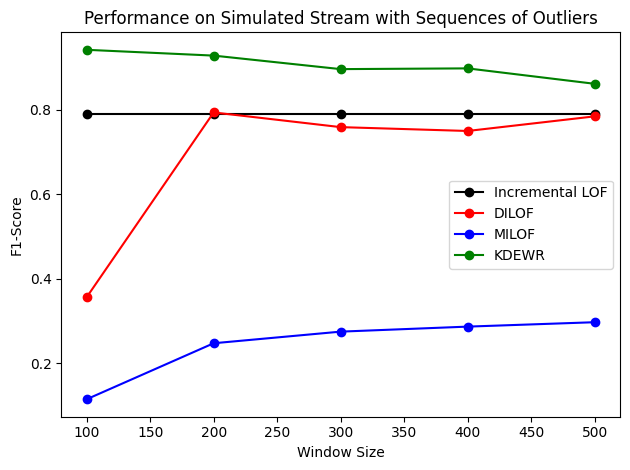

In [10]:
windows = [100,200,300,400,500]
plt.plot(windows, f_scores_handwritten[0], color = "black", marker = "o", label = "Incremental LOF" )
plt.plot(windows, f_scores_handwritten[1], color = "red", marker = "o", label = "DILOF" )
plt.plot(windows, f_scores_handwritten[2], color = "blue", marker = "o", label = "MILOF" )
plt.plot(windows, f_scores_handwritten[3], color = "green", marker = "o", label = "KDEWR" )

plt.xlabel("Window Size")
plt.ylabel("F1-Score")
plt.title("Performance on Simulated Stream with Sequences of Outliers")

plt.legend()
plt.tight_layout()
plt.show()

In [25]:
#Trying to simulate an evolving stream
random.seed(134)
X_start, y_start = generate_dataset(
    n_samples = 5000 // 3,
    centers = [[0,0], [5,5], [10,0]],
    stdevs = [1,1,1],
    center_weights = [1/3, 1/3, 1/3],
    outlier_center = [[-5,4], [20,0]],
    outlier_spread = [0.5, 3],
    outlier_prop = 0.01,
    outlier_sequence = True,
    outlier_sequence_length = 3
)

X_middle, y_middle = generate_dataset(
    n_samples = 5000 // 3,
    centers = [[0,0], [5,5], [10,0], [5,-5]],
    stdevs = [1,1,1,1],
    center_weights = [1/4, 1/4, 1/4, 1/4],
    outlier_center = [[-5,4], [20,0]],
    outlier_spread = [0.5, 3],
    outlier_prop = 0.01,
    outlier_sequence = True,
    outlier_sequence_length = 3
)

X_end, y_end = generate_dataset(
    n_samples = 5000 // 3,
    centers = [[0,0], [5,-5], [10,0]],
    stdevs = [1,1,1],
    center_weights = [1/3, 1/3, 1/3],
    outlier_center = [[-5,4], [20,0]],
    outlier_spread = [0.5, 3],
    outlier_prop = 0.01,
    outlier_sequence = True,
    outlier_sequence_length = 3
)



In [26]:
X_evolving = np.vstack((X_start, X_middle, X_end))
y_evolving = np.hstack((y_start, y_middle, y_end))

In [46]:
(c,s) = test(
        data = X_evolving,
                     method = "DILOF",
                     k = 20,
                     threshold = 2,
                     window_size = 100,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
)
f1_score(c, [l == -1 for l in y_evolving])

100%|██████████| 4998/4998 [00:12<00:00, 412.86it/s]


0.8354430379746836

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   2.,
          1.,   2.,   1.,   2.,   1.,   2.,   2.,   1.,   2.,   1.,   1.,
          3.,   1.,   2.,   1.,   9., 131., 370., 624., 675., 676., 537.,
        425., 349., 280., 199., 156., 127.,  86.,  83.,  45.,  38.,  29.,
         19.,  19.,  14.,  14.,  10.,  11.,   3.,   7.,   2.,   3.,   0.,
          3.,   2.,   1.,   0.,   2.,   1.,   1.,   2.,   2.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   1.,
          1.]),
 array([-1.        , -0.94817253, -0.89634505, -0.84451758, -0.79269011,
        -0.74086263, -0.68903516, -0.63720768, -0.58538021, -0.53355274,
        -0.48172526, -0.42989779, -0.37807032, -0.32624284, -0.27441537,
        -0.2225879 , -0.17076042, -0.11893295, -0.06710547, -0.015278  ,
         0.03654947,  0.08

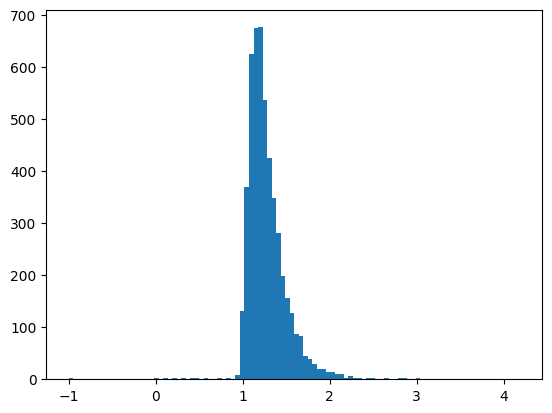

In [41]:
actual_evolving = [l == -1 for l in y_evolving]
b = [s[i] for i in range(len(s)) if actual_evolving[i]]

plt.hist(s, bins = 100)

In [47]:
actual_evolving = [l == -1 for l in y_evolving]
f_scores_evolving = [[], [], [], []]
algs = ["IncrementalLOF", "DILOF", "MILOF"]#, "KDEWR"]
for w in [100,200,300,400,500]:
    for i  in range(1,len(algs)):
        print(algs[i])
        (c,s) = test(
                     data = X_evolving,
                     method = algs[i],
                     k = 20,
                     threshold = 2,
                     window_size = w,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
        )
        f_scores_evolving[i].append(f1_score(c, actual_evolving))

#Run Incremental just once b/c it is agnostic to the window size
(c,s) = test(
                     data = X_evolving,
                     method = "IncrementalLOF",
                     k = 20,
                     threshold = 2,
                     window_size = 10,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.1,
                     forgetting = 0.8
)
f_scores_evolving[0] = [f1_score(c, actual_evolving)] * 5

DILOF


100%|██████████| 4998/4998 [00:33<00:00, 149.38it/s]


MILOF


100%|██████████| 4998/4998 [00:11<00:00, 432.05it/s]


DILOF


100%|██████████| 4998/4998 [00:27<00:00, 181.75it/s]


MILOF


100%|██████████| 4998/4998 [00:02<00:00, 2058.57it/s]


DILOF


100%|██████████| 4998/4998 [00:20<00:00, 246.49it/s]


MILOF


100%|██████████| 4998/4998 [00:02<00:00, 1703.49it/s]


DILOF


100%|██████████| 4998/4998 [00:23<00:00, 213.73it/s]


MILOF


100%|██████████| 4998/4998 [00:03<00:00, 1626.78it/s]


DILOF


100%|██████████| 4998/4998 [00:26<00:00, 190.12it/s]


MILOF


100%|██████████| 4998/4998 [00:48<00:00, 103.57it/s]


In [48]:
f_scores_evolving

[[0.40559440559440557,
  0.40559440559440557,
  0.40559440559440557,
  0.40559440559440557,
  0.40559440559440557],
 [0.8354430379746836,
  0.7262569832402235,
  0.6946107784431138,
  0.6624203821656051,
  0.6329113924050633],
 [0.3769633507853403,
  0.30416666666666664,
  0.3067226890756303,
  0.3348623853211009,
  0.36455696202531646],
 []]

In [49]:
with open('f_scores_evolving.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(f_scores_evolving)

In [50]:
for w in [100,200,300,400,500]:
        (c,s) = test(
                     data = X_evolving,
                     method = "KDEWR",
                     k = 20,
                     threshold = 2,
                     window_size = w,
                     skipping_enabled = True,
                     num_clusters = 10,
                     r = 1,
                     xi = 0.5,
                     forgetting = 0.5
        )
        f = f1_score(c, actual_evolving)
        print("With window", w, "the f-score is", f)
        f_scores_evolving[i].append(f)

100%|██████████| 4998/4998 [03:08<00:00, 26.49it/s]


With window 100 the f-score is 0.8131868131868132


100%|██████████| 4998/4998 [11:38<00:00,  7.15it/s]


With window 200 the f-score is 0.6926829268292682


100%|██████████| 4998/4998 [24:40<00:00,  3.38it/s]


With window 300 the f-score is 0.5634920634920635


100%|██████████| 4998/4998 [45:17<00:00,  1.84it/s]  


With window 400 the f-score is 0.5239852398523985


100%|██████████| 4998/4998 [1:07:37<00:00,  1.23it/s]

With window 500 the f-score is 0.5035460992907801


In [5]:
f_scores_evolving_written = [
[0.40559440559440557, 0.40559440559440557, 0.40559440559440557, 0.40559440559440557, 0.40559440559440557],
 [0.8354430379746836, 0.7262569832402235, 0.6946107784431138, 0.6624203821656051,  0.6329113924050633],
 [0.3769633507853403, 0.30416666666666664,  0.3067226890756303,  0.3348623853211009, 0.36455696202531646],
 [0.8131868131868132, 0.6926829268292682, 0.5634920634920635, 0.5239852398523985, 0.5035460992907801]]

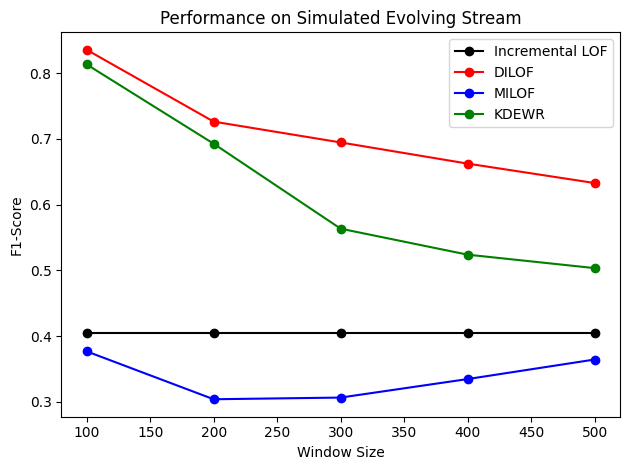

In [9]:
plt.plot(windows, f_scores_evolving_written[0], color = "black", marker = "o", label = "Incremental LOF" )
plt.plot(windows, f_scores_evolving_written[1], color = "red", marker = "o", label = "DILOF" )
plt.plot(windows, f_scores_evolving_written[2], color = "blue", marker = "o", label = "MILOF" )
plt.plot(windows, f_scores_evolving_written[3], color = "green", marker = "o", label = "KDEWR" )

plt.xlabel("Window Size")
plt.ylabel("F1-Score")
plt.title("Performance on Simulated Evolving Stream")

plt.legend()
plt.tight_layout()
plt.show()